# LFP dataset example

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr

import seaborn as sns

from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.cross_decomposition import PLSRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error

import random
# Initialize the random seed to ensure reproducibility of the results in the paper
random.seed(10)

# Test your implementations of the skewness and kurtosis etc. 
from scipy.stats import skew
from scipy.stats import kurtosis

from jax import jacfwd
import jax.numpy as jnp

import src.featlin
from src.featlin import Featlin
# from src.featlin import regress_linearized_coeff
from src.featlin import jax_moment
# from src.featlin import linearization_plots
# from src.featlin import linearization_regeression_row_plots

from src.helper import optimise_pls_cv
from src.helper import optimize_regcoef_nrmse
from src.helper import optimize_regcoef_dist
from src.helper import plot_x_tt2

import src.basis as basis
from src.basis import BasicsData

plt.style.use('./styles/plots_row.mplstyle')

%load_ext autoreload
%autoreload 2

In [2]:
save_plots = 0
save_path = './results/Linearization/'

In [3]:
# Colorblind safe palette from: https://gka.github.io/palettes/#/26|s|00429d,96ffea,ffffe0|ffffe0,ff005e,93003a|1|1 
# IBM Colors: https://www.ibm.com/design/language/color/
# https://lospec.com/palette-list/ibm-color-blind-safe

colors = ['#332bb3', '#4a31b5', '#5d37b6', '#6d3db7', '#7c43b7', '#8a49b6', '#964fb5', '#a256b3', '#ad5db1', '#b764b0', '#c16cae', '#ca75ad', '#d27eac', '#d989ab', '#e094aa', '#e7a1ab', '#ecafac', '#f0beae', '#f4cfb0', '#f6e1b4']
colors_IBM = ['#648fff', '#785ef0', '#dc267f', '#fe6100', '#ffb000',  '#000000']
cmap_ = clr.LinearSegmentedColormap.from_list('Blue-light cb-safe', colors, N=256)
cmap = clr.LinearSegmentedColormap.from_list('Blue-light cb-IBM', colors_IBM[:-1], N=256)
color_list = [colors_IBM[0], colors_IBM[2], colors_IBM[3], colors_IBM[4], colors_IBM[5]]
marker_list = ['s', 'o', 'D', 'P']

In [4]:
# Load the LFP Dataset
lfp_df = pd.read_csv('./data/lfp_slim.csv', index_col=0)

X_lfp = np.array(lfp_df.iloc[:, 0:1000])
X_lfp = X_lfp[:, ::-1]
y_lfp_true = np.array(lfp_df.iloc[:, 1000])
x_lfp = np.linspace(2.0, 3.5, 1000)

X_lfp_train = np.array(X_lfp[lfp_df.iloc[:, 1002]==0, :])
y_lfp_train_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==0])
X_lfp_test = np.array(X_lfp[lfp_df.iloc[:, 1002]==1, :])
y_lfp_test_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==1])
X_lfp_test2 = np.array(X_lfp[lfp_df.iloc[:, 1002]==2, :])
y_lfp_test2_true = np.array(y_lfp_true[lfp_df.iloc[:, 1002]==2])

labels_lfp = {'xdata_label': 'Voltage (V)', 'ydata_label': r'$\Delta \mathbf{Q}_{100\mathrm{-}10}$ (Ah)', 'row_label': 'Battery number'}

In [5]:
# Remove outlier 
id_outlier = np.where(np.mean(X_lfp_train, axis=1)==np.min(np.mean(X_lfp_train, axis=1)))
X_lfp_train = np.delete(X_lfp_train, id_outlier, axis=0)
y_lfp_train_true = np.delete(y_lfp_train_true, id_outlier, axis=0)

# Ground Truth Features
- Mean 
- Varinace
- Sum of Squares
- Skewness


In [6]:
# True underlying relationship between the measurements and some quantity we ewould like to recover/predict from measurements

# JAX numpy wrapper target function  to allow for autodifferentiation
fun_targetj = [
    lambda a : jnp.mean(a),
    lambda a : jnp.sum(a**2),
    lambda a : jnp.var(a),
    lambda x: jax_moment(x,3)/((jax_moment(x,2))**(3/2)),
    lambda x: jax_moment(x,4)/(jax_moment(x,2)**2)-3
    ]
fun_target_names = [
    'Sum',
    'Sum of Squares',
    'Variance', 
    'Skewness',
    'Kurtosis',
    ]
feat_fun_dict = {fun_target_names[i] : fun_targetj[i] for i in range(len(fun_targetj))}

# What if the relationship is actually a combination fo different functions
# Combinations based of the functions above to obtain non-linear functions of different complexity
# This is expected to show limits of the methodology
fun_target_combj = [
    lambda  a : np.array(5*fun_targetj[0](a) + fun_targetj[1](a)),
    lambda  a : np.array(3*fun_targetj[2](a) + fun_targetj[0](a)),
    lambda  a : np.array(fun_targetj[1](a) * fun_targetj[3](a)),
    lambda  a : np.array(fun_targetj[3](a) * fun_targetj[4](a))
    ]
ftarget_comb_names = [
    '5*\sum_{i=1}^n x_i + \sum_{i=1}^n x_i^2',
    '3*\text{var}(\mathbf{x}) + \sum_{i=1}^n x_i',
    '\sum_{i=1}^n x_i^2 * \text{skewness}(\mathbf{x})',
    '\text{skewneww}(\mathbf{x}) * \text{kurtosis}(\mathbf{x})'
]

# X = X_lfp_train-np.mean(X_lfp, axis=0)
# y_gt = np.zeros([X.shape[0], 5, 1])
# for j in range(len(fun_targetj)): 
#     y_gt[:, j, 0] = generate_target_values(X[:, :], fun_targetj[j], percentage_range_x_to_t=[0,1], snr=50)

In [7]:
# Generate BasicsData class objects
lfp_mean = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_mean = lfp_mean.construct_y_data(fun_targetj[0]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Mean
lfp_mean = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_mean = lfp_mean.construct_y_data(fun_targetj[0]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Sum Squares
lfp_sums = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_sums = lfp_sums.construct_y_data(fun_targetj[1]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Variance
lfp_var = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_var = lfp_var.construct_y_data(fun_targetj[2]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Skew
lfp_skew = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_lfp_skewvar = lfp_skew.construct_y_data(fun_targetj[3]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Kurt
lfp_kurt = BasicsData(X=X_lfp_train, x=x_lfp, y=None) 
lfp_kurt = lfp_kurt.construct_y_data(fun_targetj[4]).add_wgn(add_noise_X=False, add_noise_y=True, snr_y=50)

# Log Cycle Life
lfp_lcl = BasicsData(X=X_lfp_train, x=x_lfp, y=1/(np.log(y_lfp_train_true**0.01))) #np.log(y_lfp_train_true))

In [8]:
# Inititate the class with data (x, y) & features that you want to test
if 0: 
    opt_dist = {'active':False, 'model':'ridge', 'norm':2}
    lfp_meangt = Featlin(data_obj=lfp_mean, feat_funcs=feat_fun_dict)
    lfp_meangt = lfp_meangt.analyse_all_features(max_nrmse=0.1, opt_dist=opt_dist, opt_nrmse=1)

In [9]:
# Inititate the class with data (x, y) & features that you want to test
if 0: 
    opt_dist = {'active':False, 'model':'ridge', 'norm':1}
    lfp_sums_gt = Featlin(data_obj=lfp_sums, feat_funcs=feat_fun_dict)
    # Run the tests
    lfp_sums_gt = lfp_sums_gt.analyse_all_features(max_nrmse=0.1, opt_dist=opt_dist, opt_nrmse=1)
    plt.show()

In [10]:
if 0:     
    # Inititate the class with data (x, y) & features that you want to test
    opt_dist = {'active':False, 'model':'PLS', 'norm':2}
    opt_nrmse = {'active':True, 'model':'PLS', 'norm':2, 'max_comp':15}
    fig_props = {'save':True, 'ax0_xlabel':'Voltage (V)', 'save_path':'./results/VariancePLS', 'response':'',
                'multiple_fig':True}#'response':'Groundtruth Response: Variance'}

    lfp_var_gt = Featlin(data_obj=lfp_var, feat_funcs=feat_fun_dict)

    # Run the tests
    lfp_var_gt = lfp_var_gt.analyse_all_features(max_nrmse=0.05, opt_dist=opt_dist, opt_nrmse=opt_nrmse, fig_props=fig_props)
    plt.show()

In [11]:
# Inititate the class with data (x, y) & features that you want to test
opt_dist = {'active':False, 'model':'PLS', 'norm':2}
opt_nrmse = {'active':True, 'model':'PLS', 'norm':2, 'max_comp':15}
fig_props = {'save':True, 'ax0_xlabel':'Voltage (V)', 'save_path':'./results/VariancePLS', 'response':'',
             'multiple_fig':True}#'response':'Groundtruth Response: Variance'}

lfp_var_gt = Featlin(data_obj=lfp_var, feat_funcs=feat_fun_dict)


In [12]:
#plt.plot(lfp_var_gt.data.x, lfp_var_gt.data.X_std.T)
#plt.show()

1
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=5.0e-02 % is 0.002
1
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=5.0e-02 % is 0.002
3
['PLS 3 comp', 'lfun']
Gamma value corresponding to nrmse=5.0e-02 % is 0.054
1
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=5.0e-02 % is 0.003
1
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=5.0e-02 % is 0.002


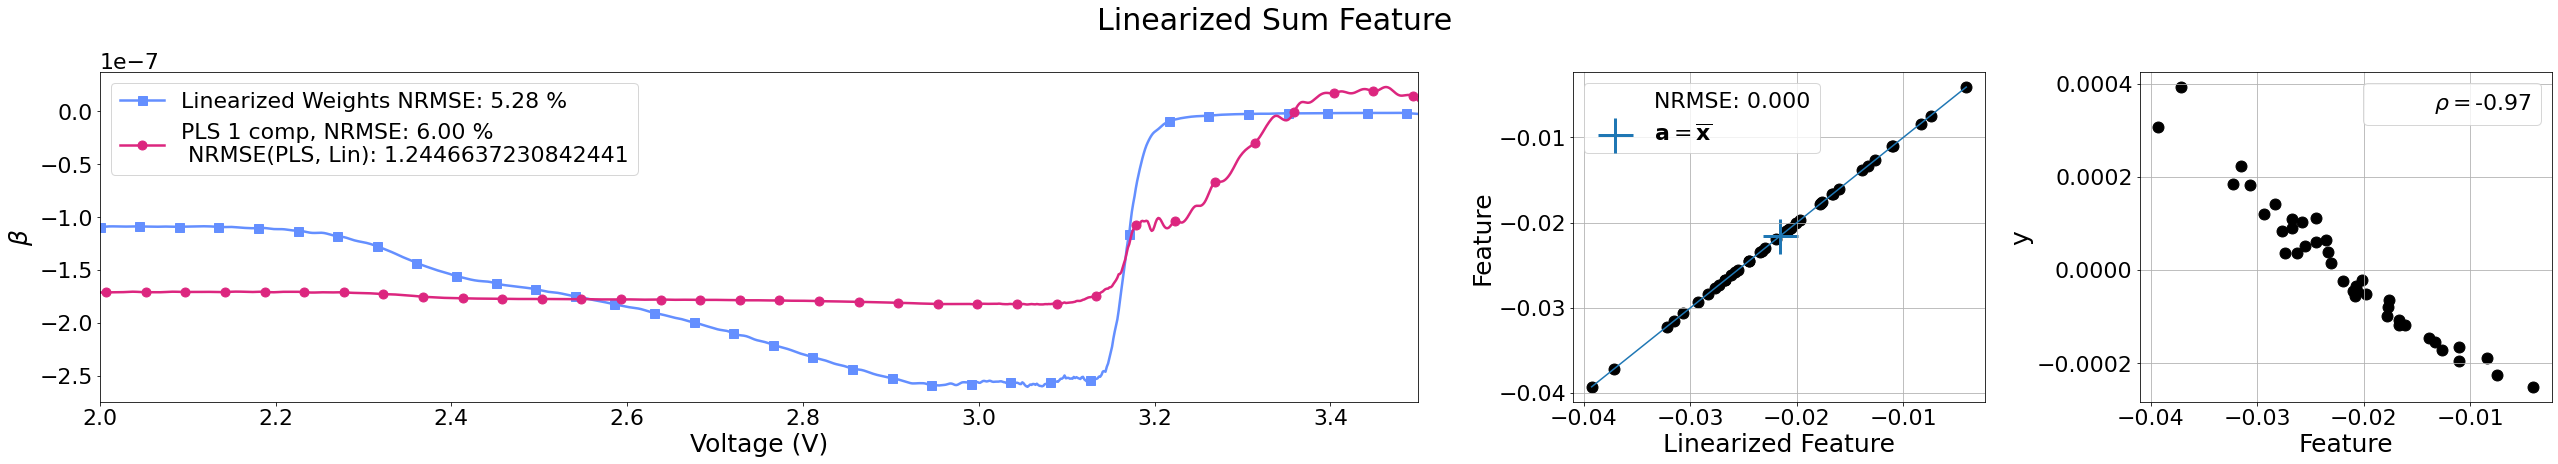

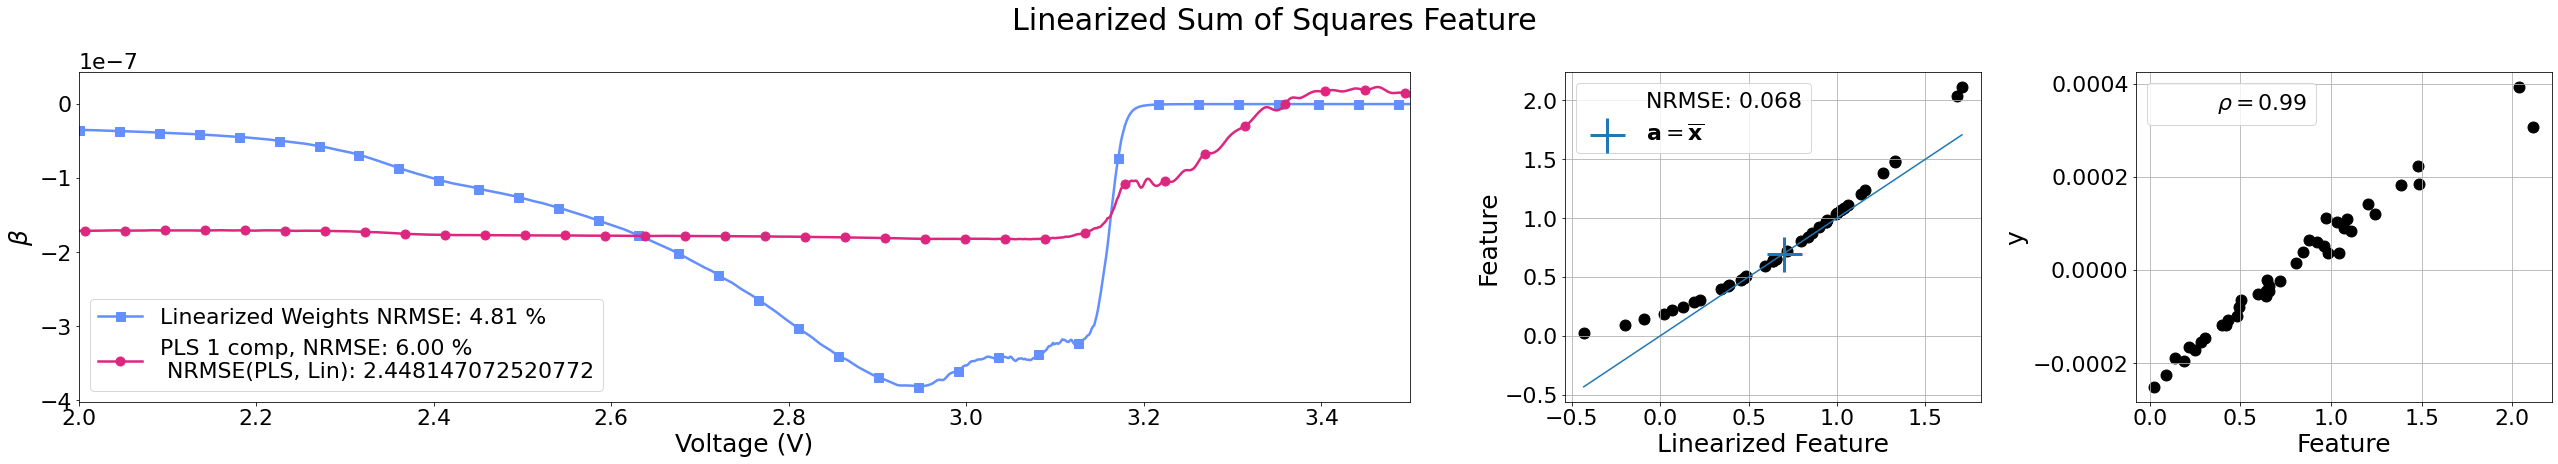

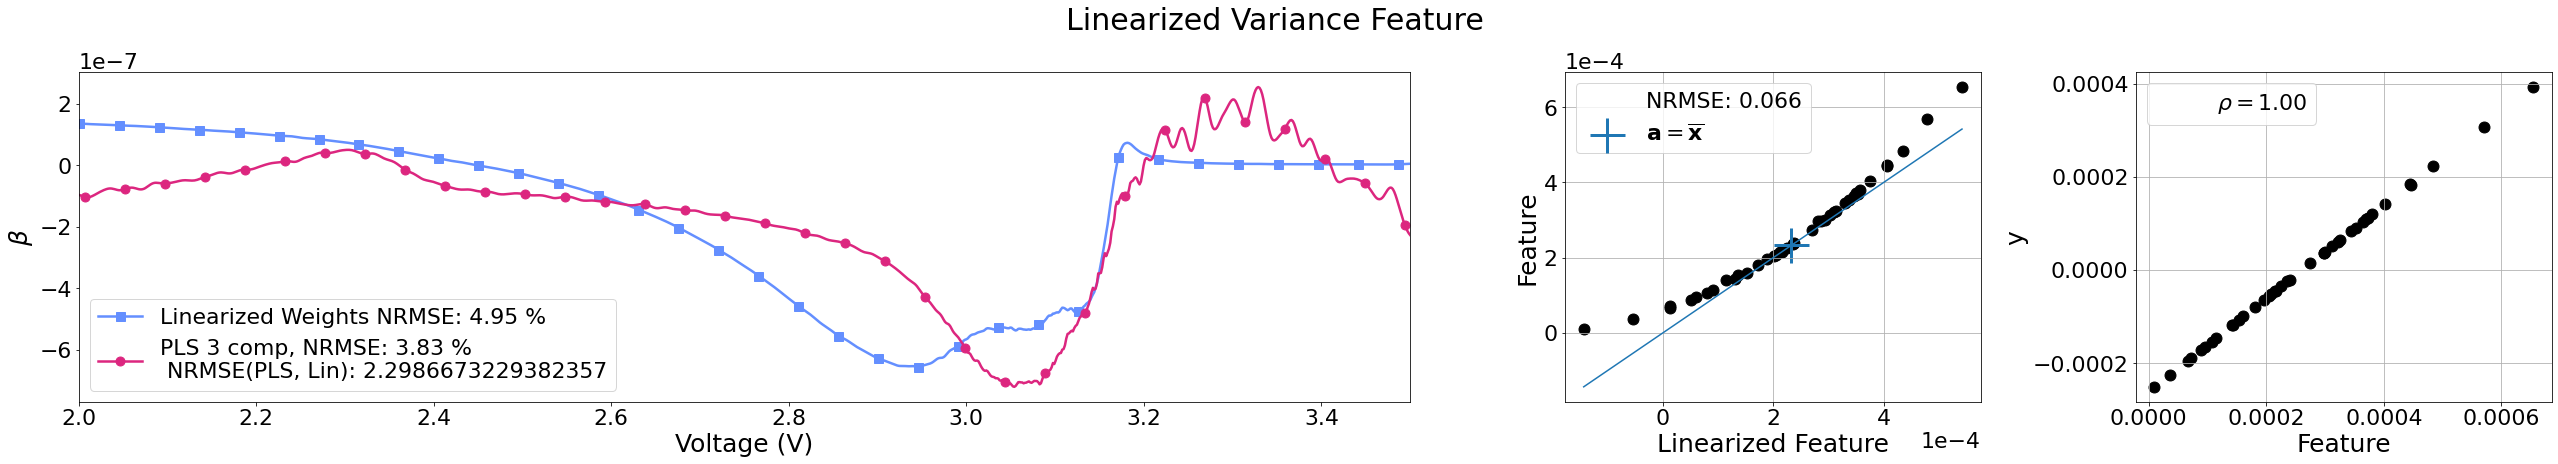

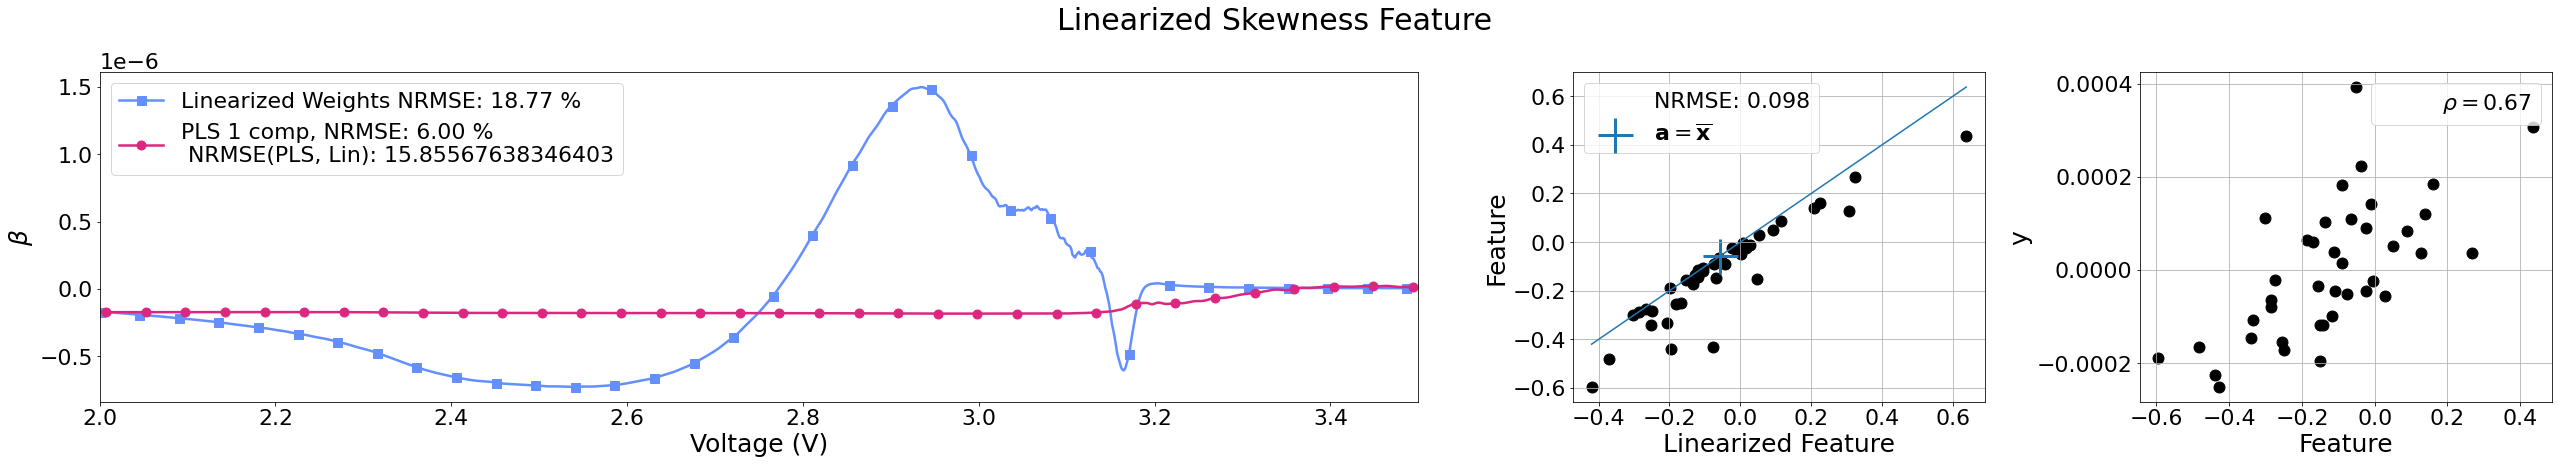

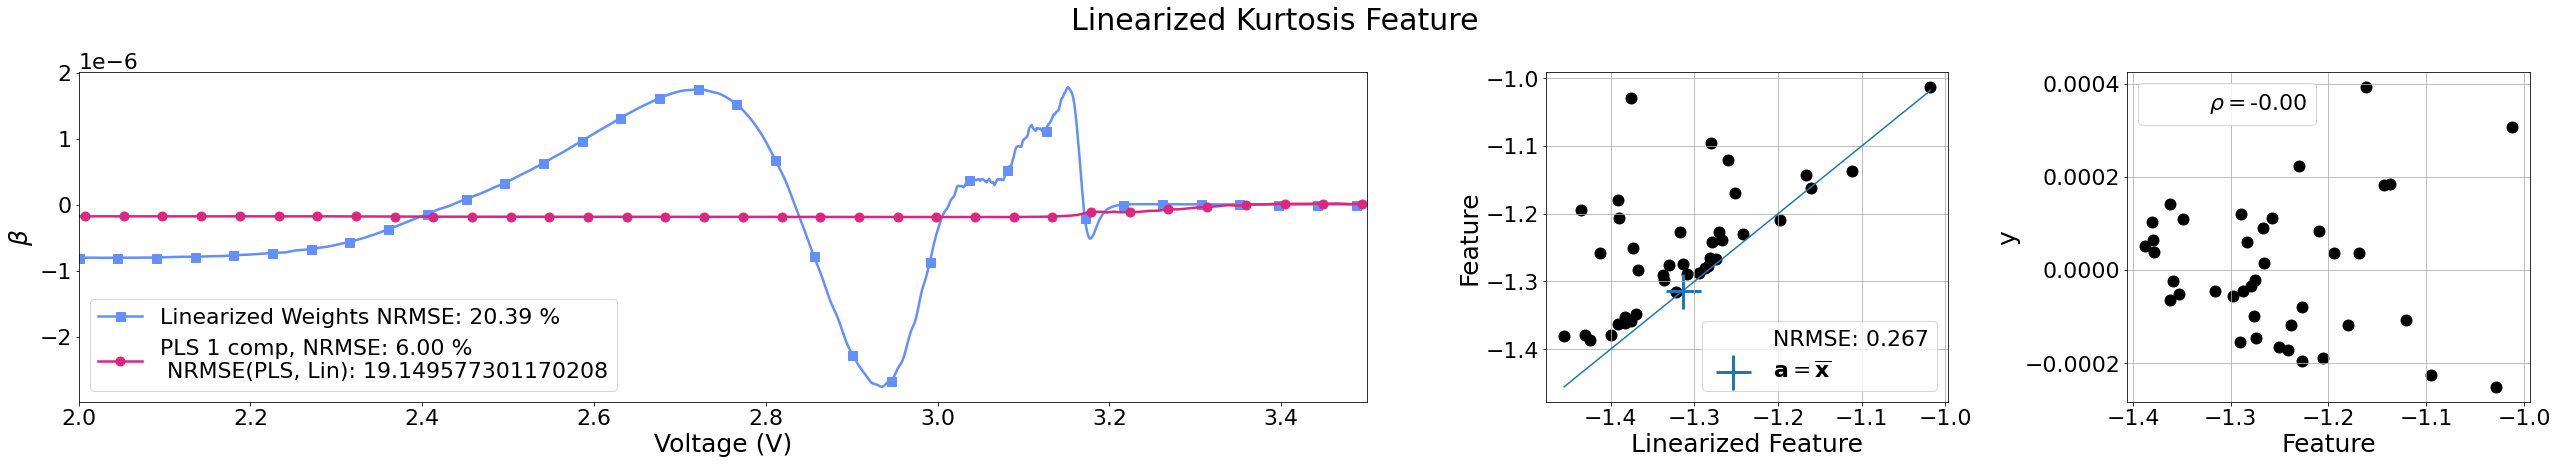

In [13]:
# Run the tests
lfp_var_gt = lfp_var_gt.analyse_all_features(max_nrmse=0.05, opt_dist=opt_dist, opt_nrmse=opt_nrmse, fig_props=fig_props, std=True)
plt.show()

 Alpha: 0.1000, corresponding to 1.9721
['RR: 0.10000', 'lfun']
Gamma value corresponding to nrmse=5.0e-02 % is 524.885
 Alpha: 0.1000, corresponding to 1.1394
['RR: 0.10000', 'lfun']
Gamma value corresponding to nrmse=5.0e-02 % is 426.532
 Alpha: 0.0446, corresponding to 2.4877
['RR: 0.04455', 'lfun']
Gamma value corresponding to nrmse=5.0e-02 % is 691.790
 Alpha: 10.0000, corresponding to 9.7135
['RR: 10.00000', 'lfun']


KeyboardInterrupt: 

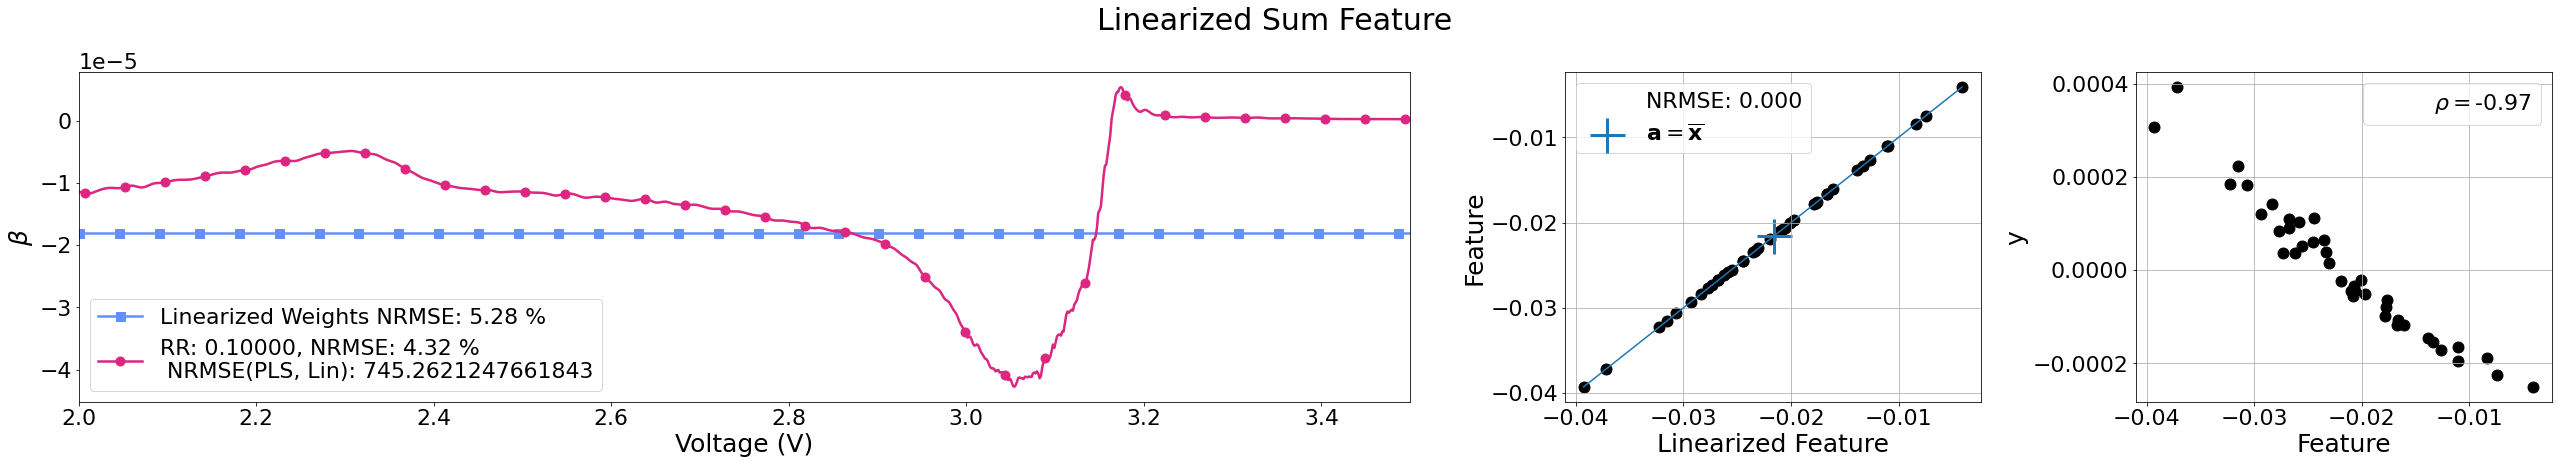

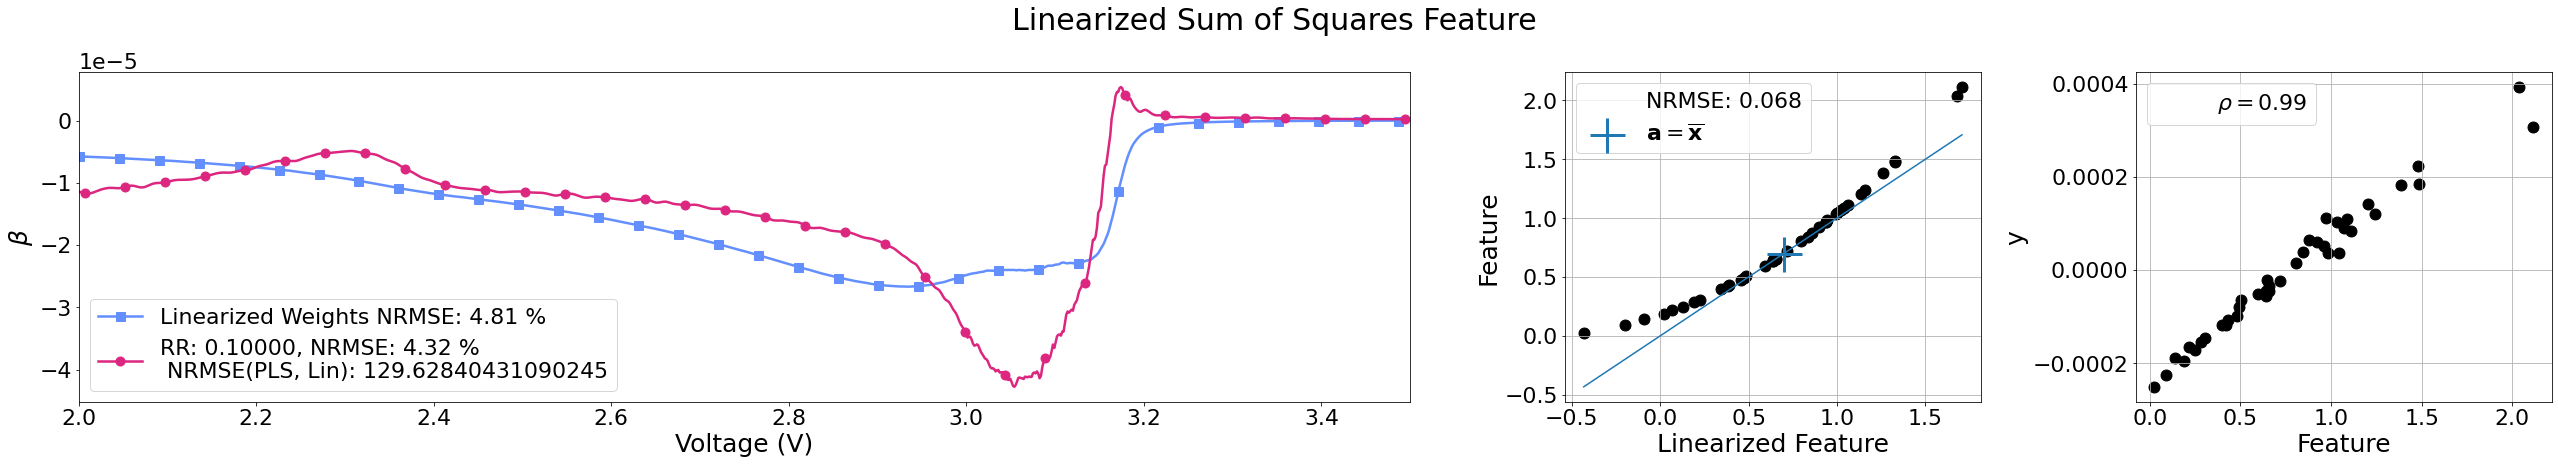

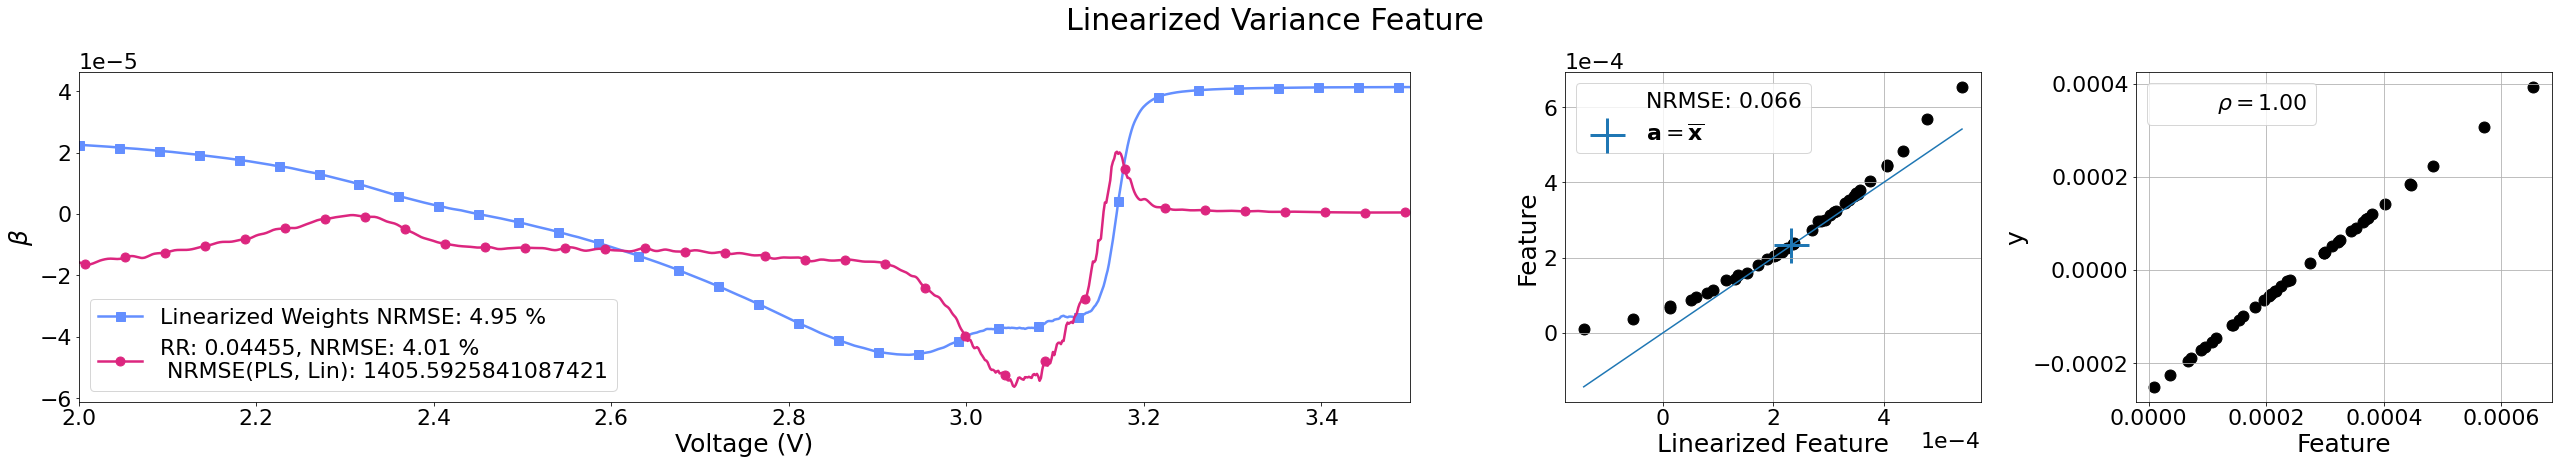

In [14]:
# Inititate the class with data (x, y) & features that you want to test
opt_dist = {'active':False, 'model':'PLS', 'norm':2}
opt_nrmse = {'active':True, 'model':'ridge', 'norm':2, 'max_comp':15}
fig_props = {'save':True, 'ax0_xlabel':'Voltage (V)', 'save_path':'./results/VarianceRR', 'response':'',
            'multiple_fig':True}#'response':'Groundtruth Response: Variance'}

lfp_var_gt = Featlin(data_obj=lfp_var, feat_funcs=feat_fun_dict)

# Run the tests
lfp_var_gt = lfp_var_gt.analyse_all_features(max_nrmse=0.05, opt_dist=opt_dist, opt_nrmse=opt_nrmse, fig_props=fig_props)
plt.show()

1
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=5.0e-02 % is 0.004


NameError: name 'y' is not defined

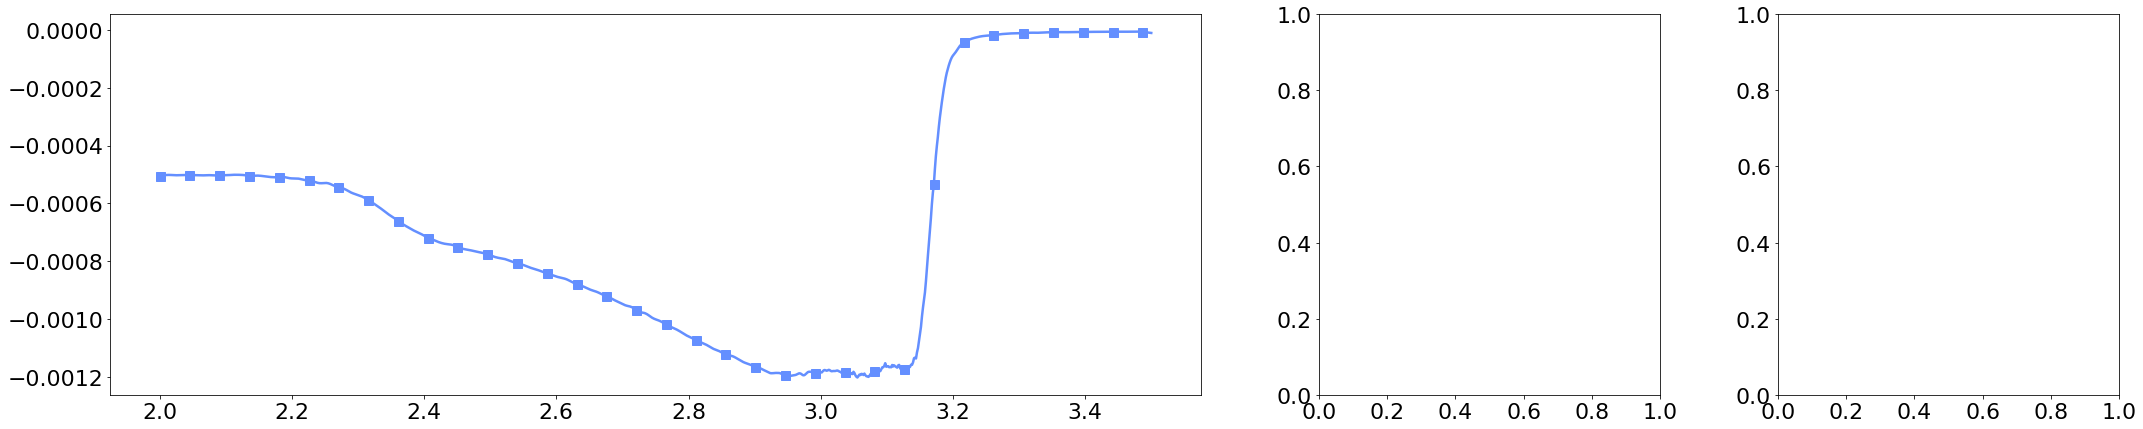

In [ ]:
# Inititate the class with data (x, y) & features that you want to test
opt_dist = {'active':False, 'model':'PLS', 'norm':2}
opt_nrmse = {'active':True, 'model':'PLS', 'norm':2, 'max_comp':15}
fig_props = {'save':False, 'ax0_xlabel':'Voltage (V)', 'save_path':'./results/LCL_PLS', 'response':'',
            'multiple_fig':True} #'response':'Response: Log Cycle Life'}

fl_lfp_lcl = Featlin(data_obj=lfp_lcl, feat_funcs=feat_fun_dict)

# Run the tests
fl_lfp_lcl = fl_lfp_lcl.analyse_all_features(max_nrmse=0.05, opt_dist=opt_dist, opt_nrmse=opt_nrmse, fig_props=fig_props, std=True)
plt.show()

['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=1.5e-01 % is 20.831
['PLS 1 comp', 'lfun']
['PLS 2 comp', 'lfun']
Gamma value corresponding to nrmse=1.5e-01 % is 128.148
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=1.5e-01 % is 203.191
['PLS 1 comp', 'lfun']
Gamma value corresponding to nrmse=1.5e-01 % is 1167.347


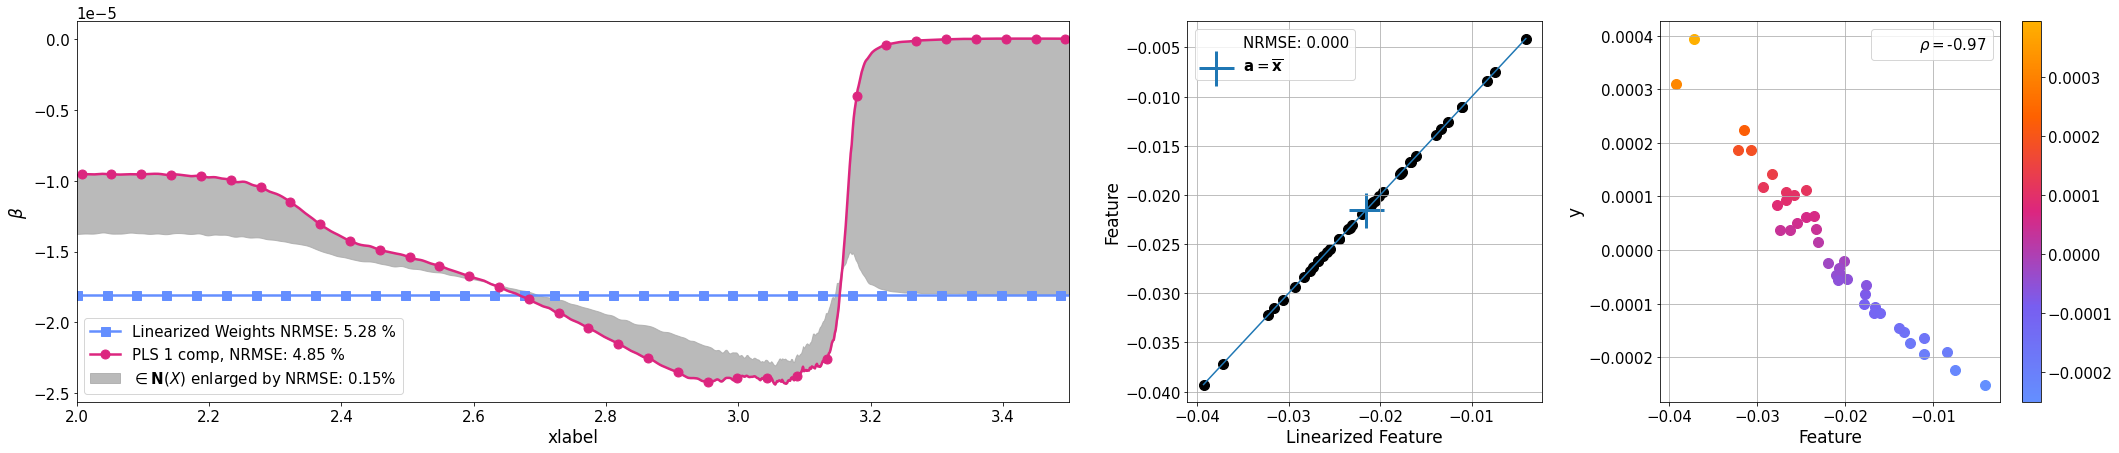

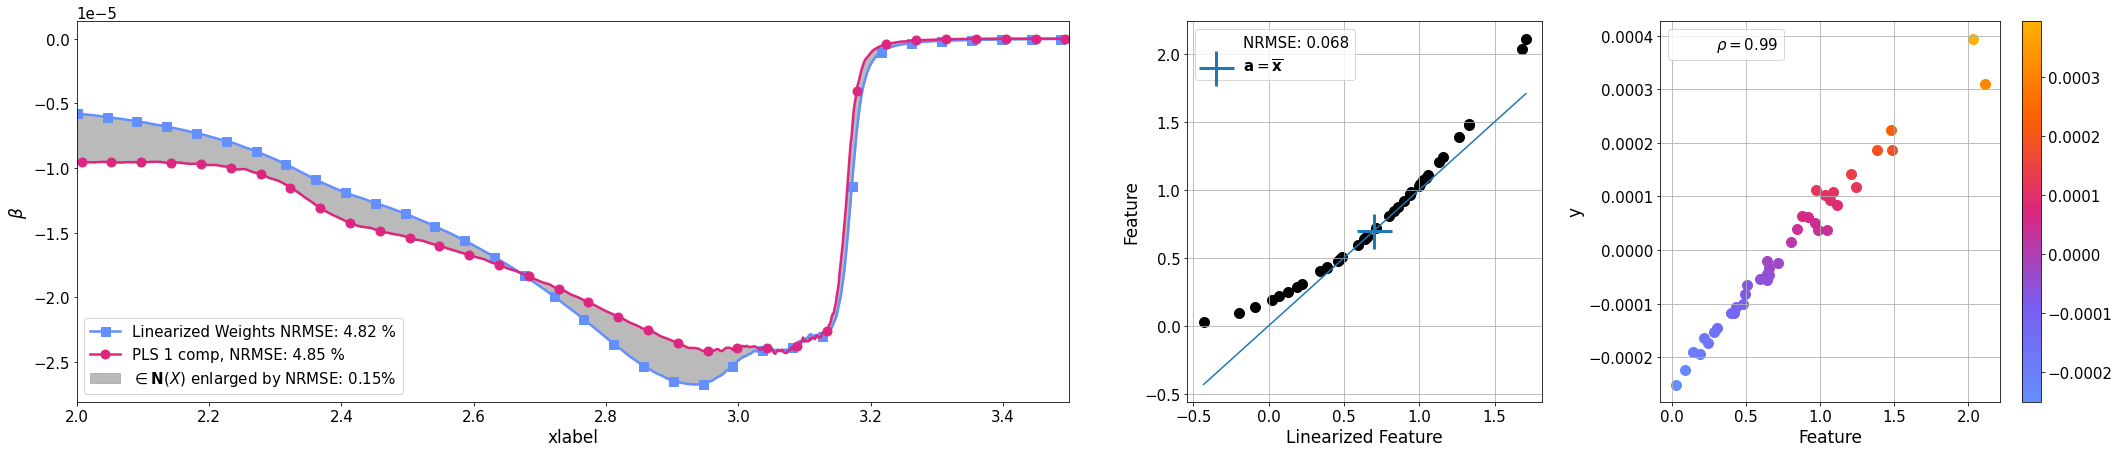

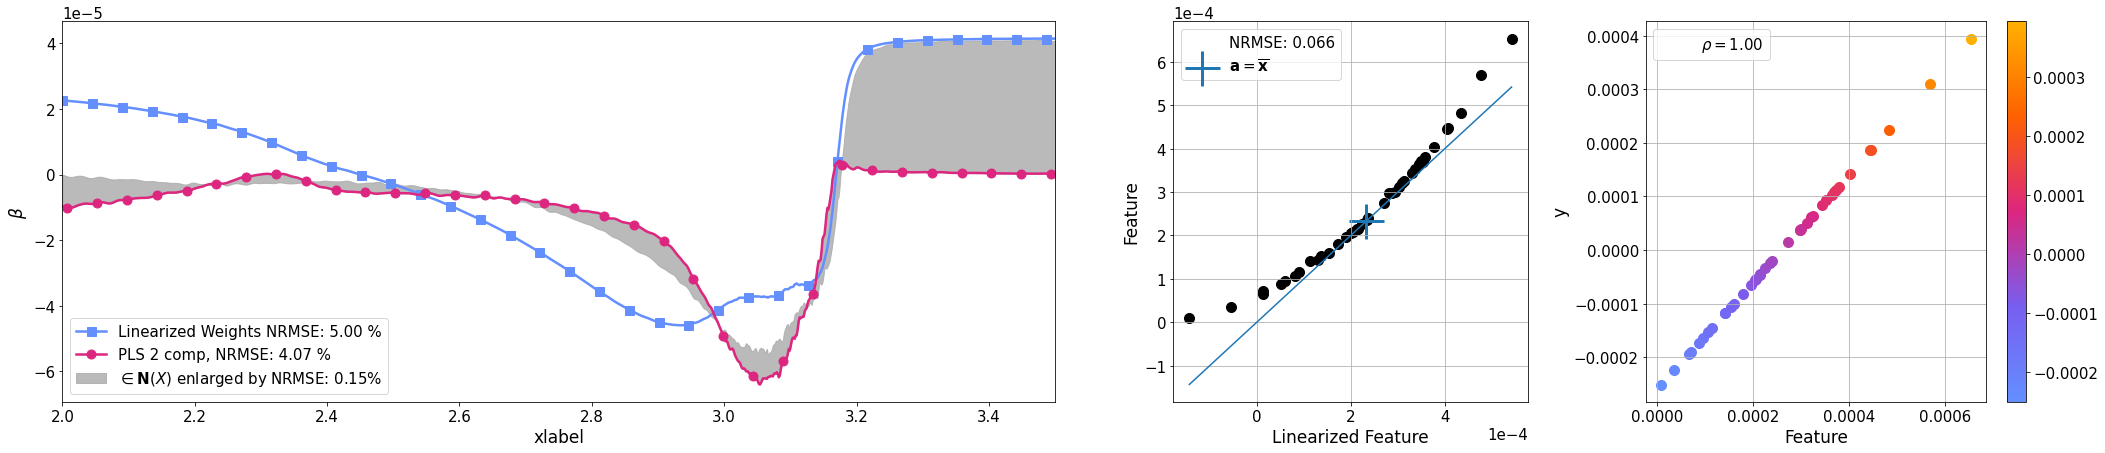

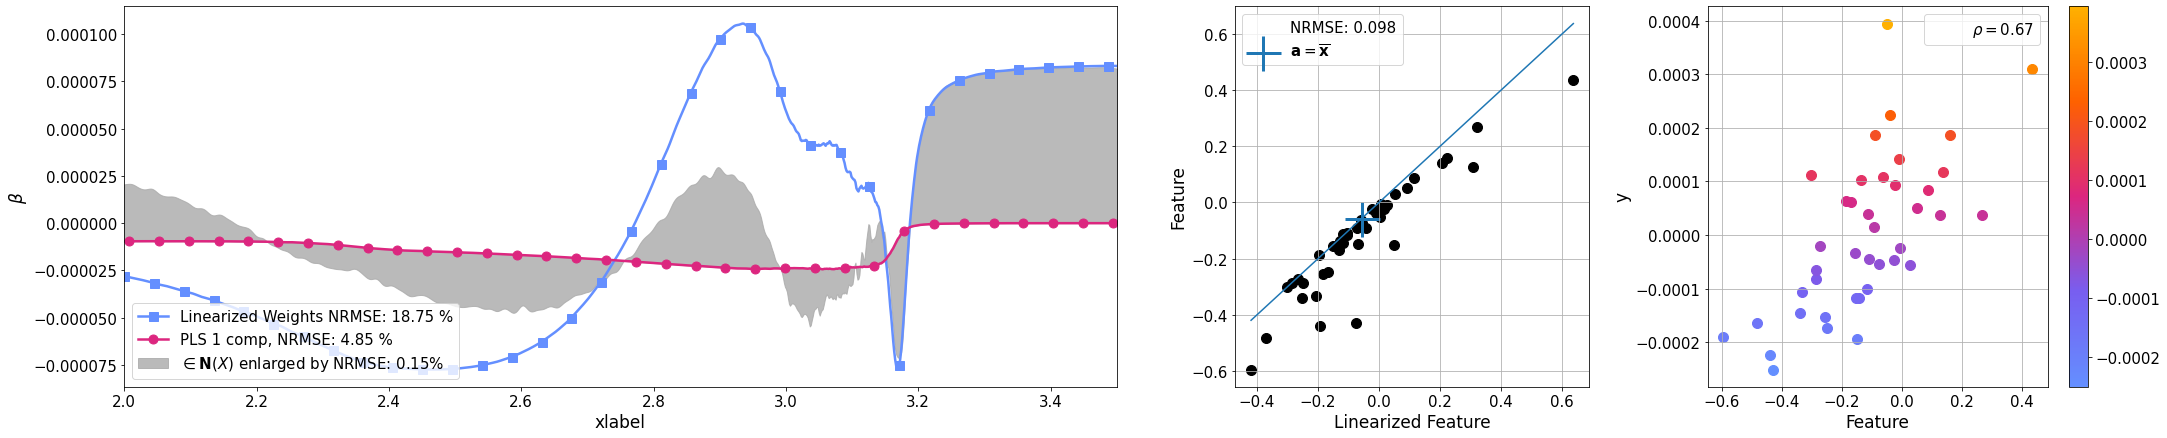

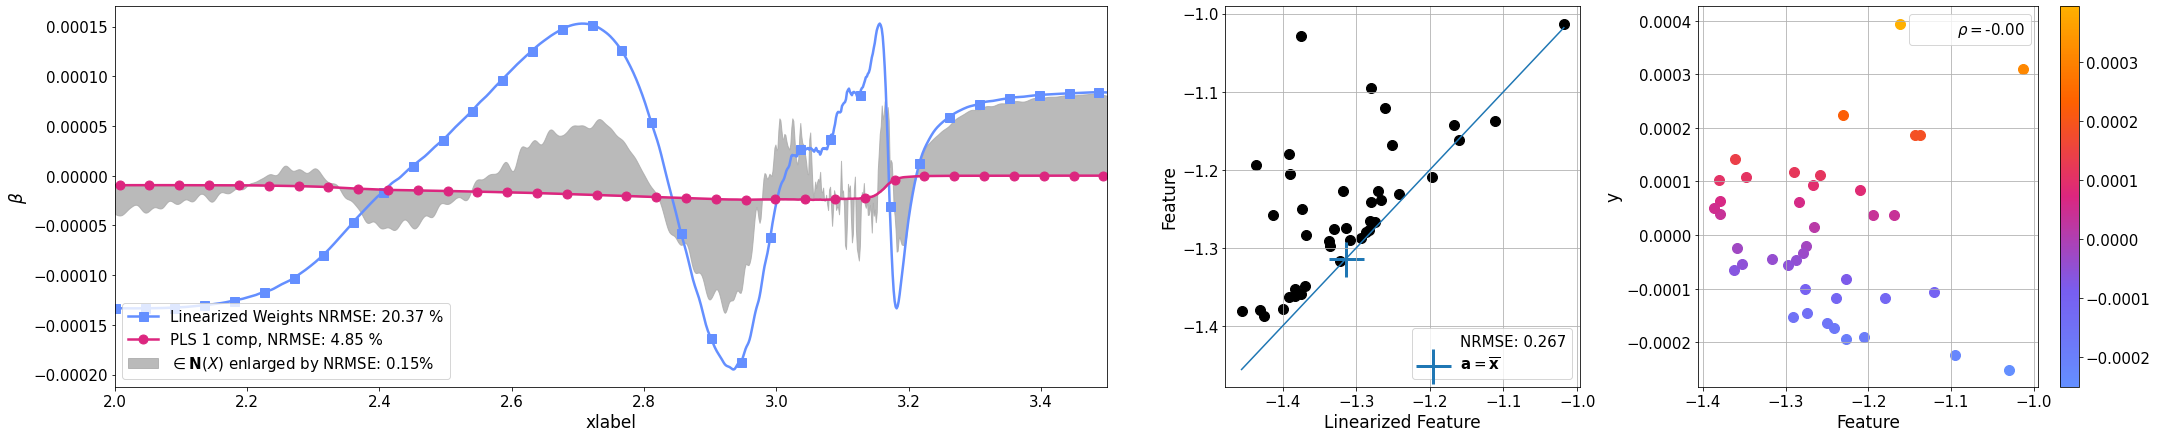

In [ ]:
if 0: 
    # Inititate the class with data (x, y) & features that you want to test
    opt_dist = {'active':True, 'model':'PLS', 'norm':2}
    opt_nrmse = {'active':False, 'model':'PLS', 'norm':2, 'max_comp':15}
    lfp_var_gt = Featlin(data_obj=lfp_var, feat_funcs=feat_fun_dict)

    # Run the tests
    lfp_var_gt = lfp_var_gt.analyse_all_features(max_nrmse=0.15, opt_dist=opt_dist, opt_nrmse=opt_nrmse)
    plt.show()

['RR: 0.62880', 'lfun']
Gamma value corresponding to nrmse=1.5e-01 % is 0.521
['RR: 0.42036', 'lfun']
Gamma value corresponding to nrmse=1.5e-01 % is 0.696
['RR: 0.12676', 'lfun']
Gamma value corresponding to nrmse=1.5e-01 % is 46.166
['RR: 8.67484', 'lfun']
Gamma value corresponding to nrmse=1.5e-01 % is 81.356
['RR: 15.27048', 'lfun']
Gamma value corresponding to nrmse=1.5e-01 % is 228.669


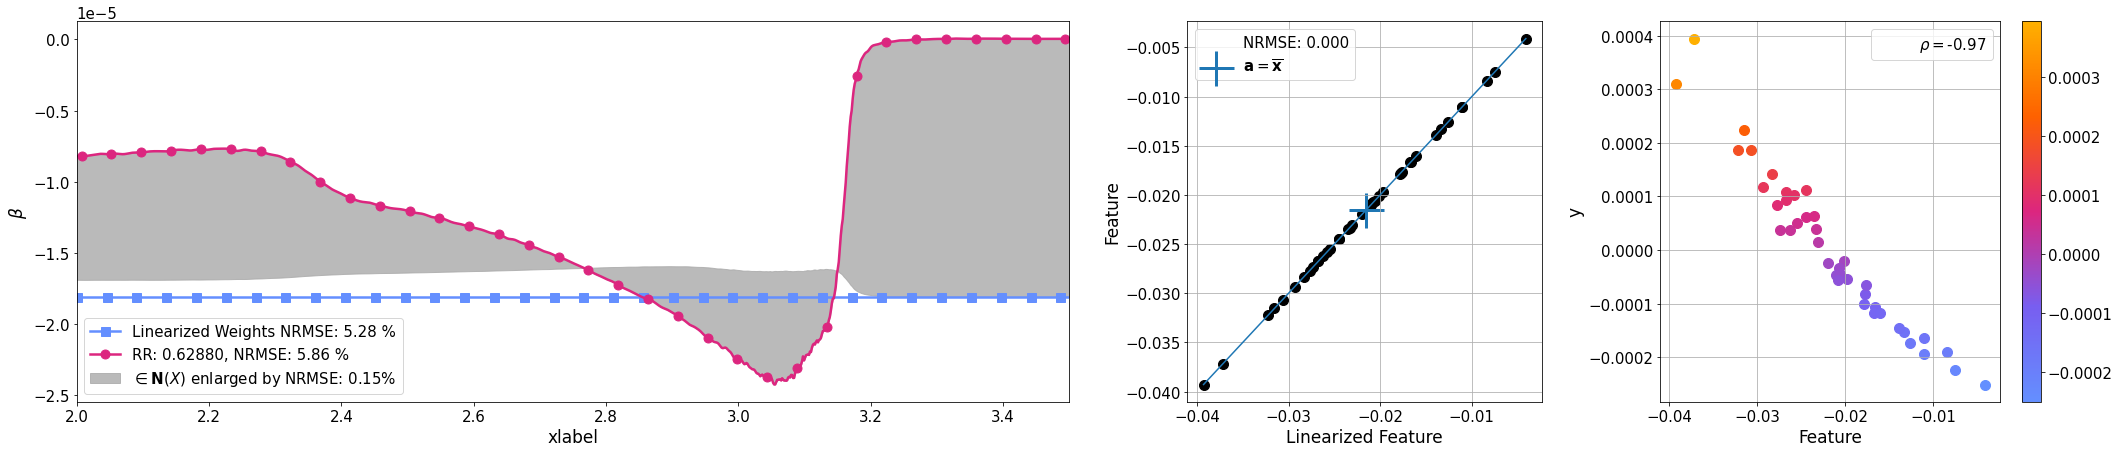

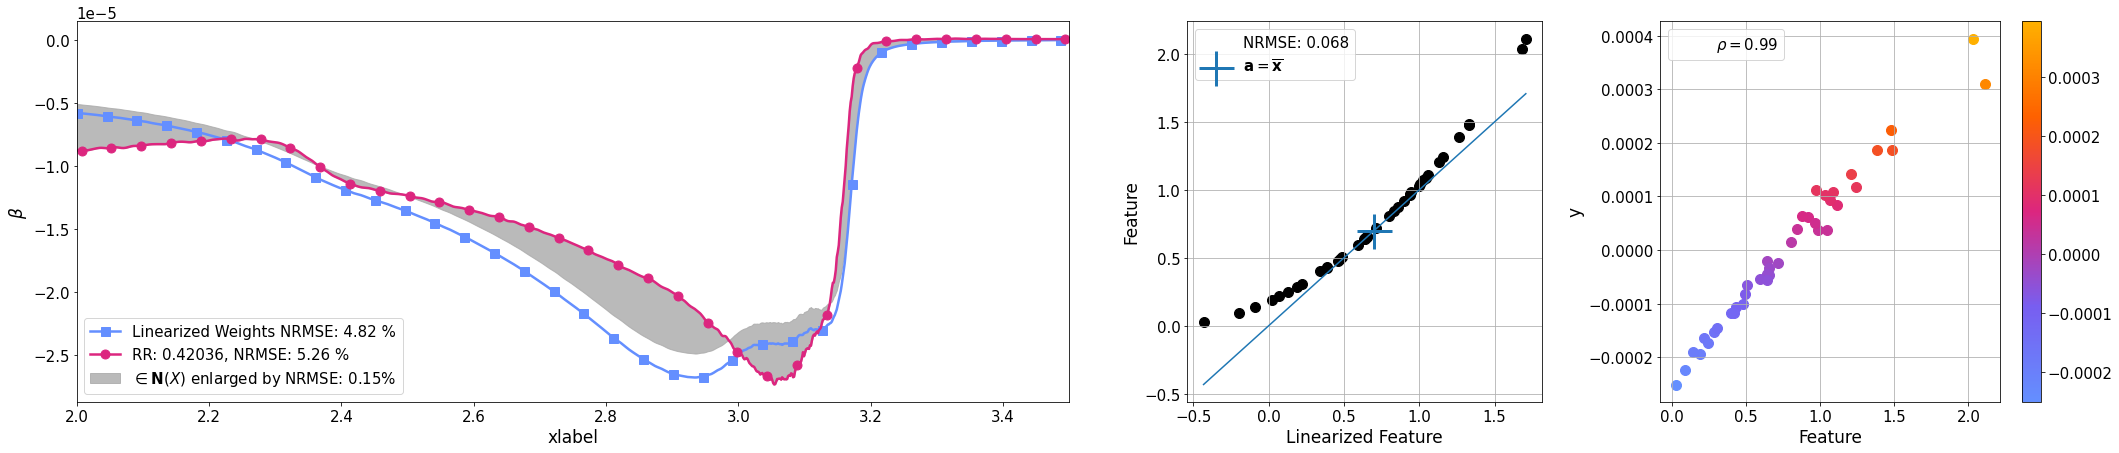

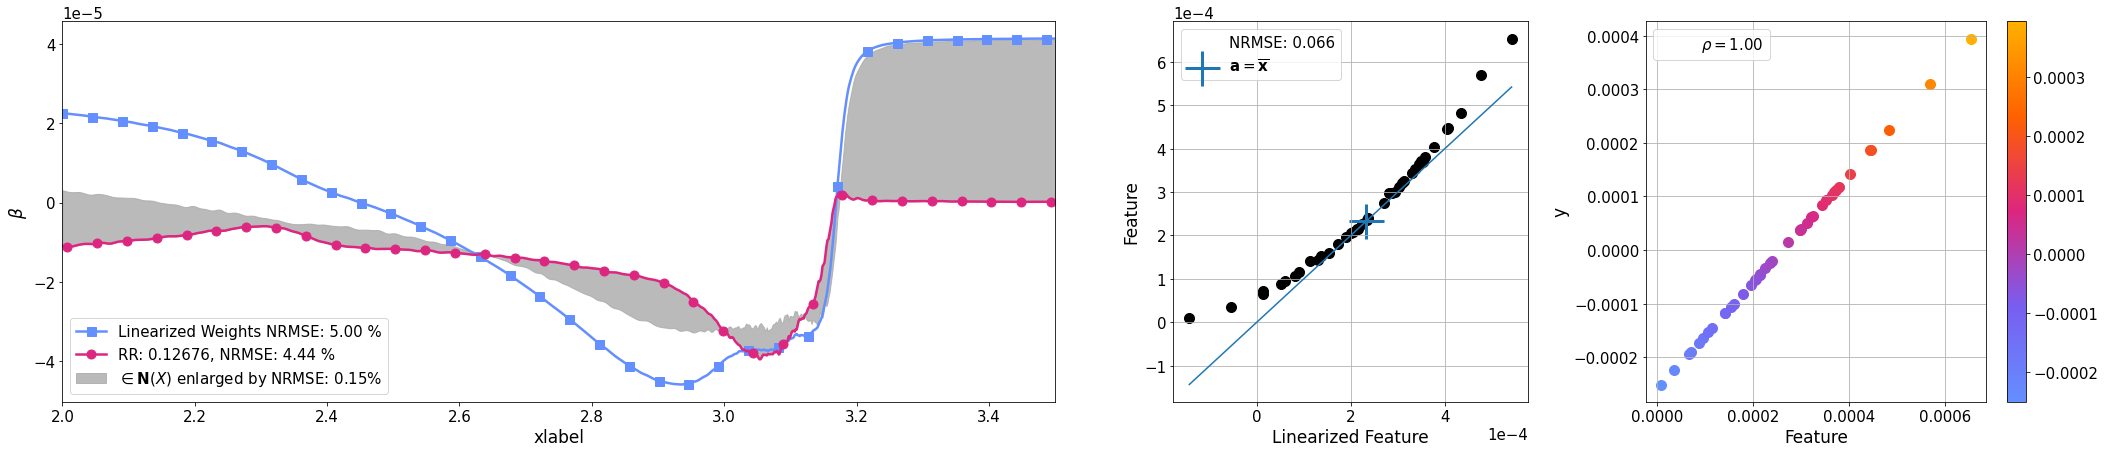

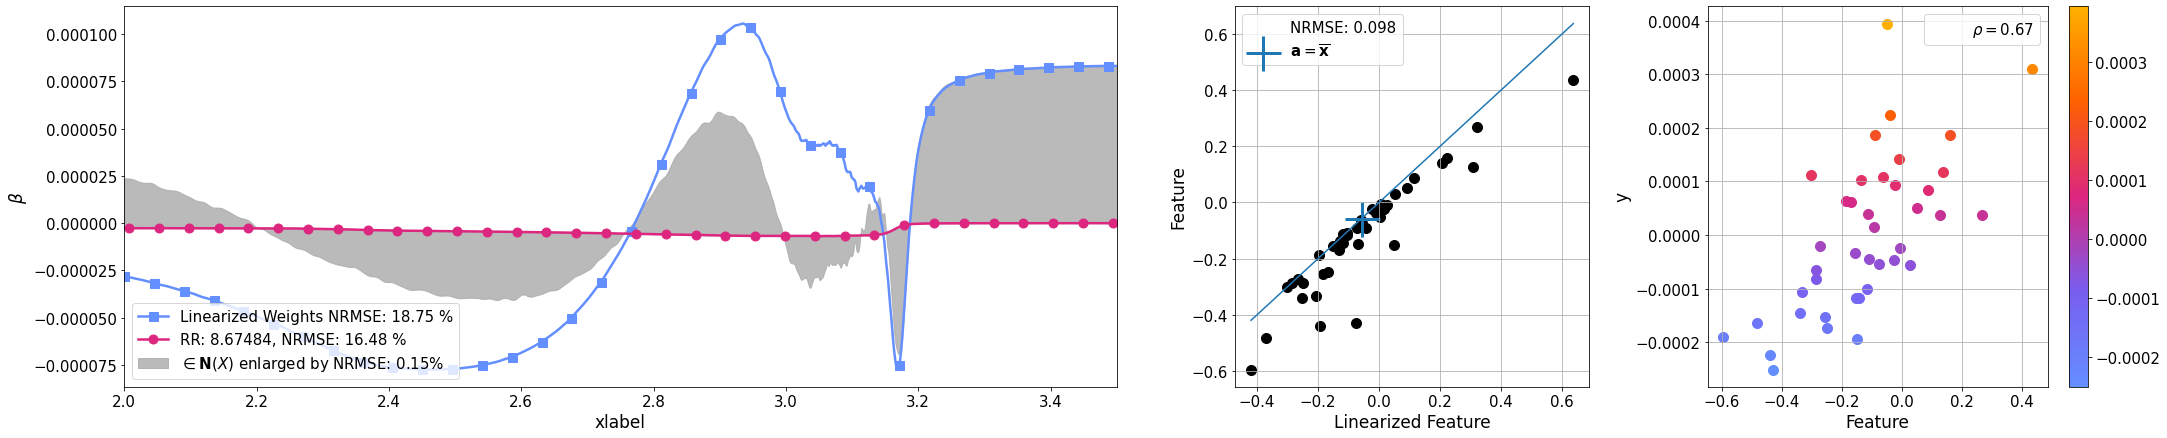

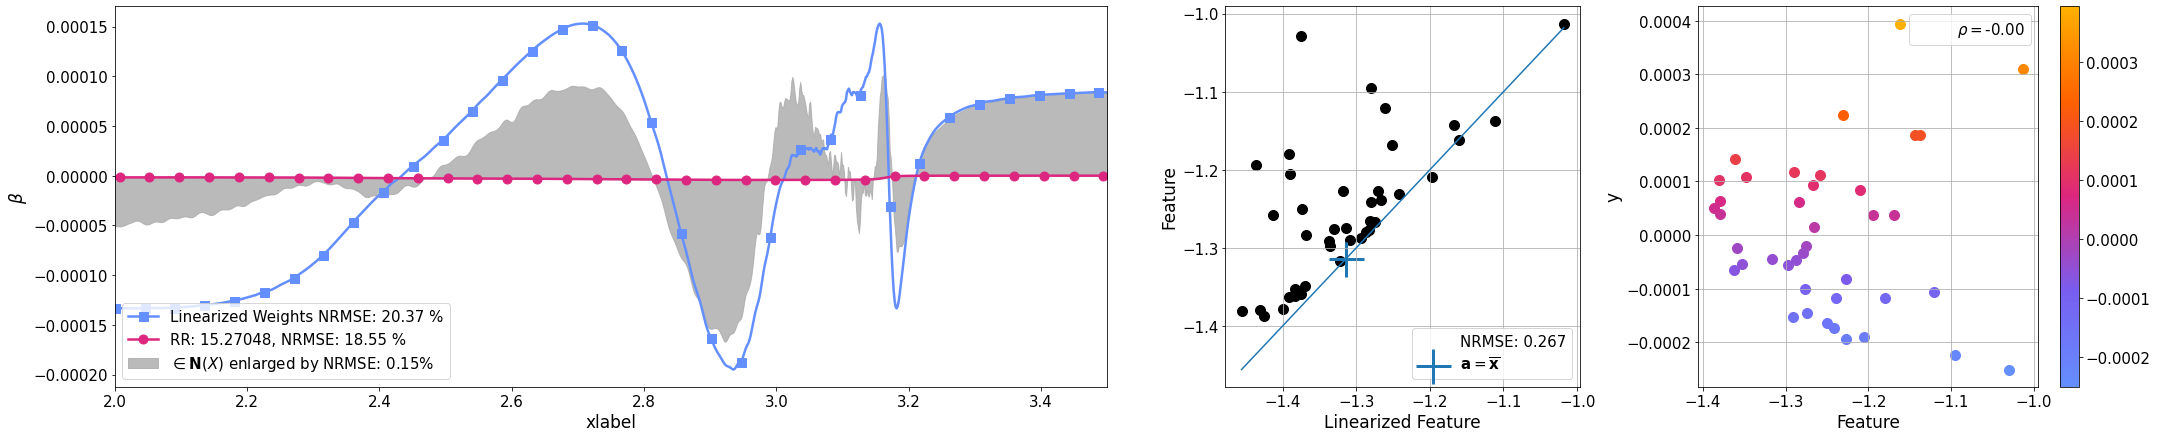

In [ ]:
if 0: 
    # Inititate the class with data (x, y) & features that you want to test
    opt_dist = {'active':True, 'model':'ridge', 'norm':2}
    opt_nrmse = {'active':False, 'model':'PLS', 'norm':2, 'max_comp':15}
    lfp_var_gt = Featlin(data_obj=lfp_var, feat_funcs=feat_fun_dict)

    # Run the tests
    lfp_var_gt = lfp_var_gt.analyse_all_features(max_nrmse=0.15, opt_dist=opt_dist, opt_nrmse=opt_nrmse)
    plt.show()

 Alpha: 0.1000, corresponding to 1.9616
['RR: 0.10000', 'lfun']
Gamma value corresponding to nrmse=1.5e-01 % is 105.894


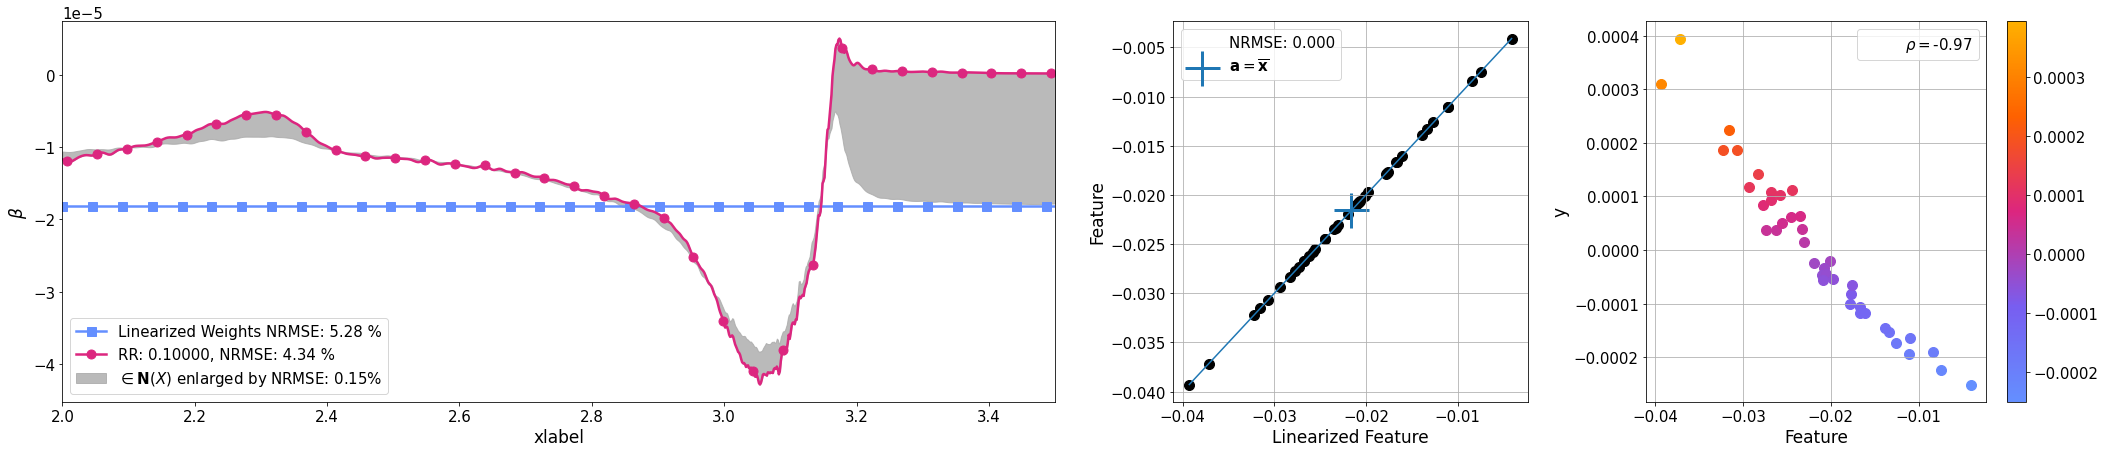

In [ ]:
if 0: 
    # Inititate the class with data (x, y) & features that you want to test
    opt_dist = {'active':False, 'model':'ridge', 'norm':2}
    opt_nrmse = {'active':True, 'model':'ridge', 'norm':2, 'max_comp':15}
    fig_props = {'save':True, 'ax0_xlabel':'Voltage (V)', 'save_path':'./results/'}

    lfp_var_gt = Featlin(data_obj=lfp_var, feat_funcs=feat_fun_dict)

    # Run the tests
    lfp_var_gt = lfp_var_gt.analyse_all_features(max_nrmse=0.15, opt_dist=opt_dist, opt_nrmse=opt_nrmse, fig_props=fig_props)
    plt.show()

In [ ]:
if 0: 
    # Inititate the class with data (x, y) & features that you want to test
    lfp_skew_gt = Featlin(data_obj=lfp_skew, feat_funcs=feat_fun_dict)

    # Run the tests
    lfp_skew_gt = lfp_skew_gt.analyse_all_features(opt_nrmse=0, max_nrmse=0.15, opt_dist=1)
    plt.show()

TypeError: 'int' object is not subscriptable

['PLS 1 comp', 'lfun']
Alpha NRMSE: 23.918235073894902
Beta NRMSE: 24.348933882504014
Max NRMSE: 0.15
Gamma value corresponding to nrmse=1.5e-01 % is 74.086
['PLS 1 comp', 'lfun']
Alpha NRMSE: 23.918235073894902
Beta NRMSE: 24.294642583927036
Max NRMSE: 0.15
Gamma value corresponding to nrmse=1.5e-01 % is 67.402
['PLS 1 comp', 'lfun']
Alpha NRMSE: 23.918235073894902
Beta NRMSE: 24.046766146925005
Max NRMSE: 0.15
['PLS 1 comp', 'lfun']
Alpha NRMSE: 23.918235073894902
Beta NRMSE: 23.090509475638036
Max NRMSE: 0.15
Gamma value corresponding to nrmse=1.5e-01 % is 236.287
['PLS 2 comp', 'lfun']
Alpha NRMSE: 14.26798364874667
Beta NRMSE: 18.661301699025145
Max NRMSE: 0.15
Gamma value corresponding to nrmse=1.5e-01 % is 138.713


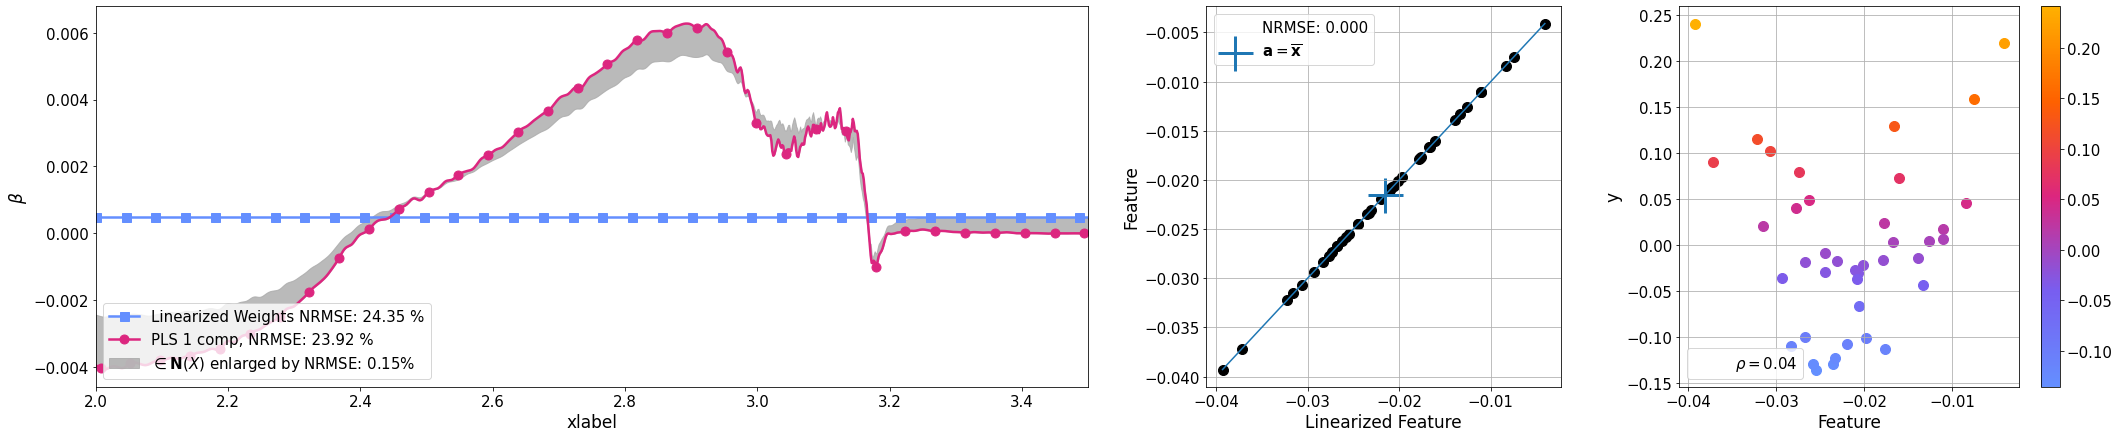

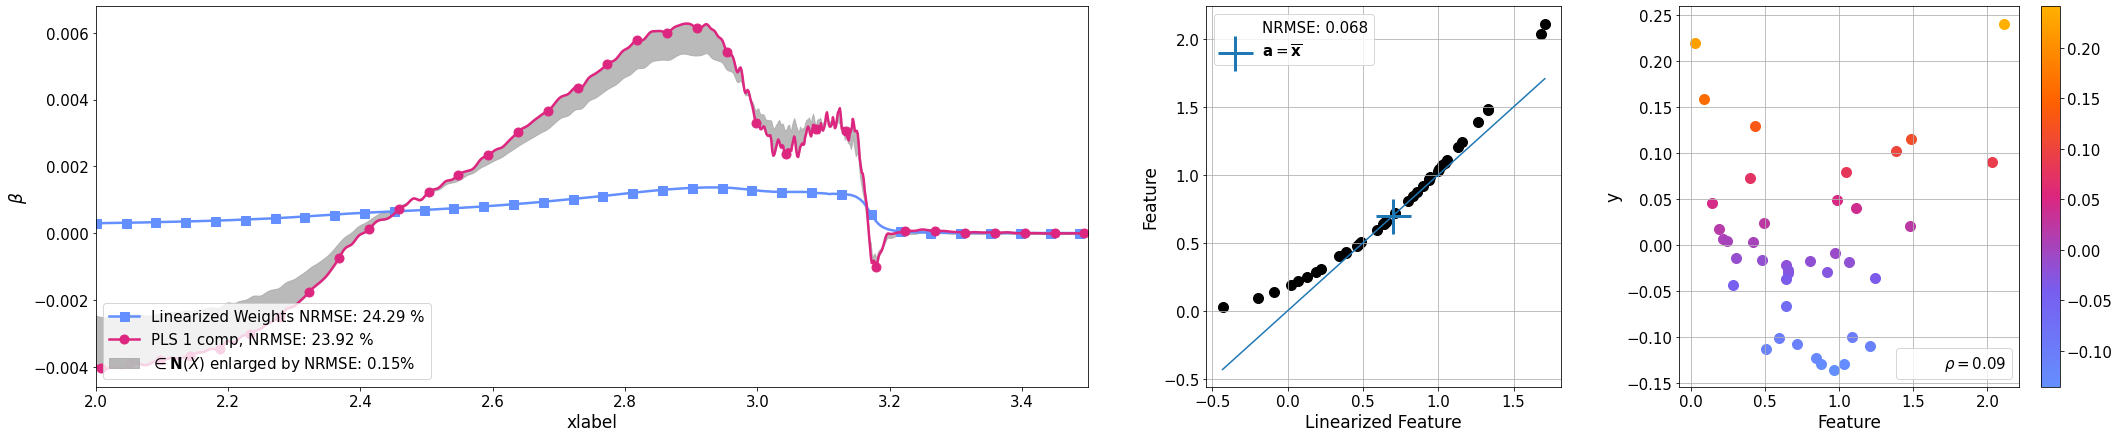

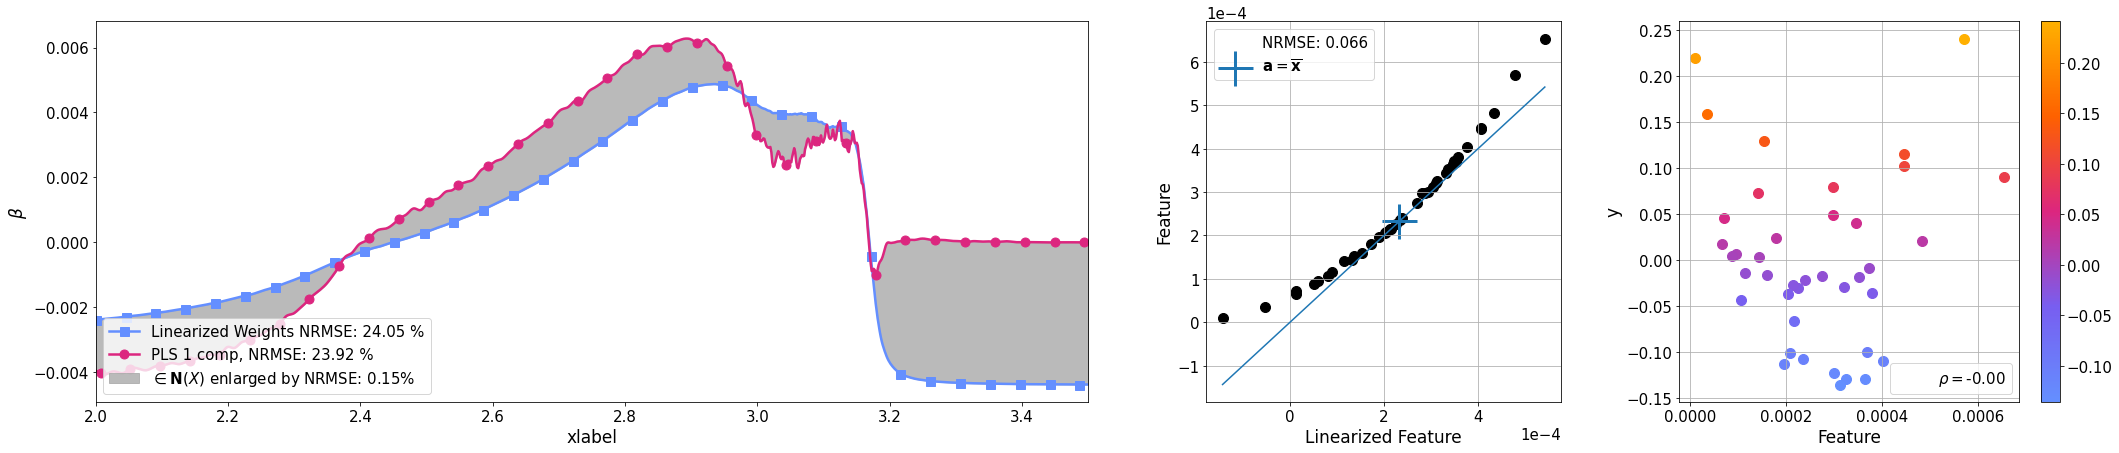

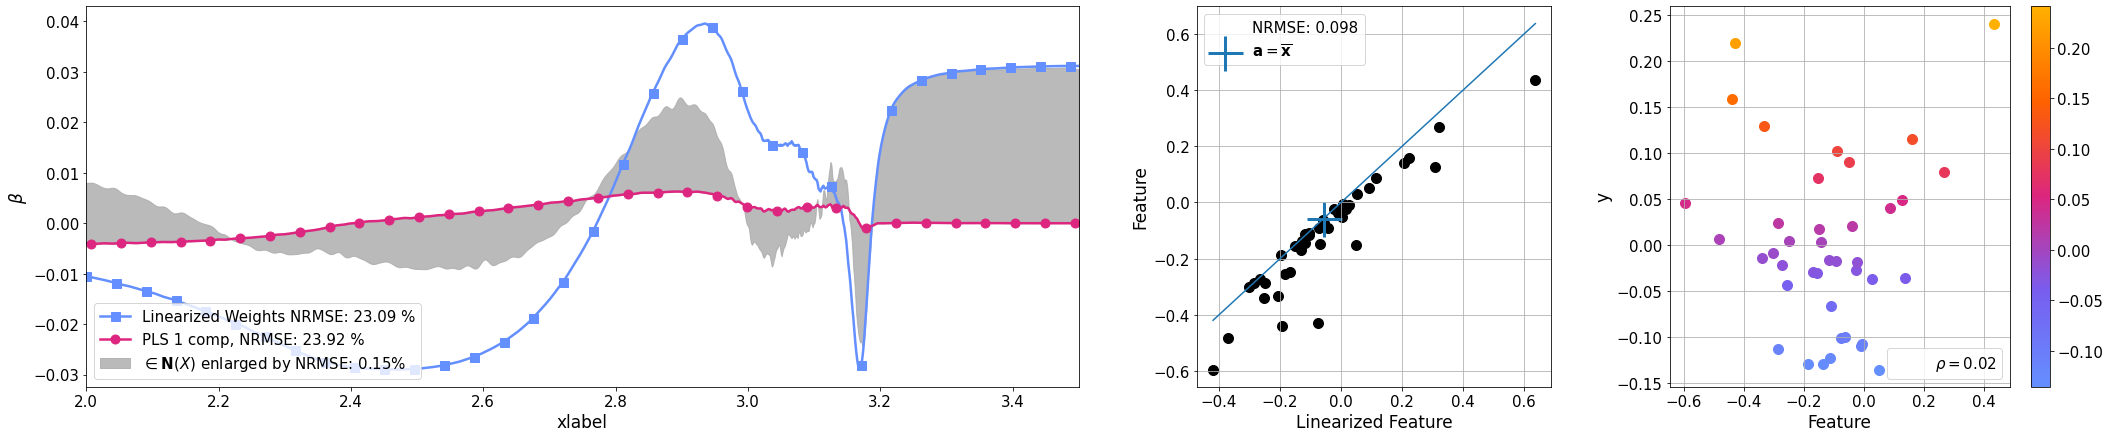

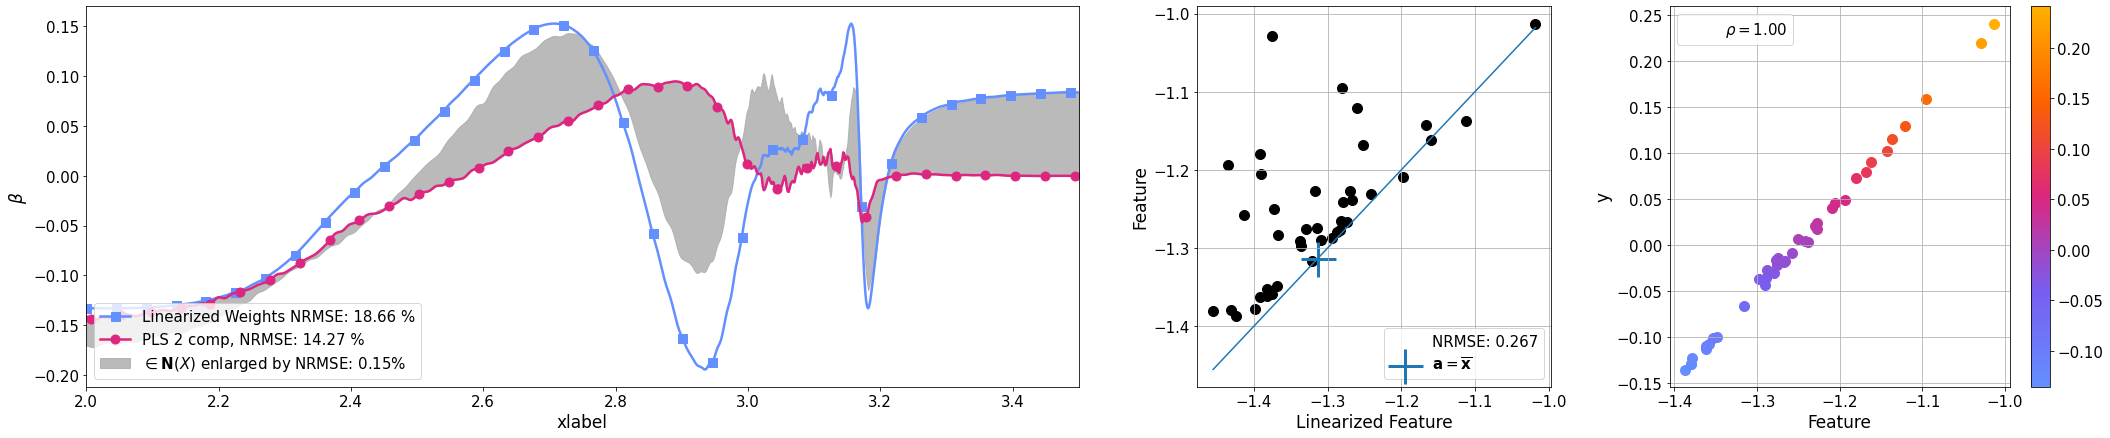

In [ ]:
if 0: 
    # Inititate the class with data (x, y) & features that you want to test
    lfp_kurt_gt = Featlin(data_obj=lfp_kurt, feat_funcs=feat_fun_dict)

    # Run the tests
    lfp_kurt_gt = lfp_kurt_gt.analyse_all_features(opt_nrmse=0, max_nrmse=0.15, opt_dist=1)
    plt.show()

In [ ]:
# Write functions that creates reuslts table: 

#Feature #NRMSE_Linearized #Closest_PLS_Model #NRMSE_PLS #Closest_RR_Model #NRMSE_RR #Pearson_Corr_Coefficient